# Intro

{Fill in with information about this notebook}

# Set Up notebook 

In [2]:
#Import modules
import numpy as np #Data manipulation
import pandas as pd #Point data manipulation and organization
import xarray as xr #Raster data manipulation and organization

import pathlib  #For filepaths, io, etc.
import os       #For several system-based commands
import datetime #For manipulation of time data, including file creation/modification times
import json     #For dictionary io, etc.

import matplotlib.pyplot as plt #For plotting and data vizualization
import geopandas as gpd         #For organization and manipulation of vector data in space (study area and some data points)
import rioxarray as rxr         #For orgnaization and manipulation of raster data
from scipy import interpolate
import shapely                  #For converting coordinates to point geometry

#Scripts with functions made for this specific application
import w4h

#Variables needed throughout, best to just assign now
todayDate, dateSuffix = w4h.getCurrentDate() 
repoDir = pathlib.Path(os.getcwd())

# Read in data

- Set up filepaths
- Read in data from:
    - downholeData table (from database)
    - headerData table (from database)
    - xyzData file (from previously carried out work) (will eventually make this updateable)

Read in data

In [3]:
directoryDir = r'\\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\BedrockWellData\Wells\RawWellData_OracleDatabase\TxtData\\'[:-1]
downholeDataPATH, headerDataPATH, xyzInPATH  = w4h.filesSetup(db_dir=directoryDir)

#Functions to read data into dataframes. Also excludes extraneous columns, and drops header data with no location information
headerDataIN, downholeDataIN = w4h.readRawTxtData(downholefile=downholeDataPATH, headerfile=headerDataPATH) 
xyzDataIN = w4h.readXYZData(xyzfile=xyzInPATH)

Most Recent version of this file is : ISGS_DOWNHOLE_DATA_2023-01-06.txt
Most Recent version of this file is : ISGS_HEADER_2023-01-06.txt
Most Recent version of this file is : xyzData.csv
Using the following files:

\\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\BedrockWellData\Wells\RawWellData_OracleDatabase\TxtData\ISGS_DOWNHOLE_DATA_2023-01-06.txt
\\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\BedrockWellData\Wells\RawWellData_OracleDatabase\TxtData\ISGS_HEADER_2023-01-06.txt
\\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\BedrockWellData\Wells\RawWellData_OracleDatabase\TxtData\xyzData.csv
Downhole Data has 3054409 valid well records.
Header Data has 636855 unique wells with valid location information.


Define datatypes (doing this during the read in process has presented issues)

In [4]:
#Define datatypes, to read into defineDataTypes() function
#Define datatypes of each column of the new dataframes
downholeDataIN = w4h.defineDataTypes(downholeDataIN, dtypeFile='downholeDataTypes.txt')
headerDataIN = w4h.defineDataTypes(headerDataIN, dtypeFile='headerDataTypes.txt')
xyzDataIN = w4h.defineDataTypes(xyzDataIN, dtypeFile='xyzDataTypes.txt')

#Make a copy of the data so raw data is preserved while we work with the rest of the data
downholeData = downholeDataIN.copy()
headerData = headerDataIN.copy()
xyzData = xyzDataIN.copy()

Read in Study Area

In [5]:
import w4h
studyAreaPath = r"\\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\ISWS_HydroGeo\WellDataAutoClassification\SampleData\ESL_StudyArea_5mi.shp"
#studyAreaPath = r"C:\Users\balikian\OneDrive - University of Illinois - Urbana\Data_OneDrive\CodesScripts\MahometBoreholesPolygon.zip"
studyAreaIN = w4h.read_study_area(studyAreaPath)

Read in/Define Model Grid, surface elevation grid, and bedrock elevation grid

In [6]:
modelGridPath = r"\\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\ISWS_HydroGeo\WellDataAutoClassification\SampleData\grid_625_raster.tif"
surfaceElevPath = r"\\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\ISWS_HydroGeo\WellDataAutoClassification\SampleData\ILStateLidar_ClipExtentESL.tif"
bedrockElevPath = r"\\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\ISWS_HydroGeo\WellDataAutoClassification\SampleData\ESLBedrock.tif"

modelGrid = w4h.read_grid(datapath=modelGridPath, grid_type='model', studyArea=studyAreaIN,  read_grid=True, clip2SA=True)#, gridcrs='EPSG:26715', studyAreacrs='EPSG:26715')
surfaceElevGridIN = w4h.read_grid(datapath=surfaceElevPath, grid_type='surface', studyArea=studyAreaIN, use_service=False, clip2SA=True)
bedrockElevGridIN = w4h.read_grid(datapath=bedrockElevPath, grid_type='bedrock', studyArea=studyAreaIN, use_service=False, clip2SA=True)

Add in Control points

In [7]:
#NEED CODE HERE FOR ADDING IN CONTROL Wells MANUALLY
#Add control headerInfo
#Add control description info

# Extract Elevation Data

Extract elevation data from consistent elevation dataset for all wells (lidar or other statewide DEM)

In [8]:
#First, get wells with updated xyz info
    #Check first if xyzData needs to be updated with locations (?)
    #Check which wells in headerData don't have associated lidar data

#statewideLidar =  ow
#mapping.rastertoPoints_extract()

Merge elevation data with headerData table

In [9]:
uniqueWells = headerData['API_NUMBER'].unique()
#xyzData['UniqueWells'] = uniqueWells

headerData = w4h.addElevtoHeader(xyzData, headerData)
##NEED TO UPDATE THIS TO WORK WITH DATA WITH NO XYZ ELEVATION DATA FROM LIDAR
#Change xyz column name to indicate lidar
#Use order of preference: lidar, headerData table?/30/10m DEM?

# Data Cleaning

## First, let's clean up records in the data without the necessary information

Clip data from outside Study Area

In [10]:
headerData = w4h.coords2Geometry(df=headerData, xCol='LONGITUDE', yCol='LATITUDE', crs='EPSG:4269')
#headerData['geometry']=headerData['GEOMETRY'].copy() #old code
headerDataClip = w4h.clipHeader2StudyArea(studyarea=studyAreaIN, headerdata=headerData, headerCRS='EPSG:4269')
headerData = headerDataClip.copy()
headerData

,API_NUMBER,TOTAL_DEPTH,SECTION,TWP,TDIR,RNG,RDIR,MERIDIAN,QUARTERS,ELEVATION,ELEVREF,COUNTY_CODE,ELEVSOURCE,LATITUDE,LONGITUDE,ELEV_FT,geometry
0,1073025512,280.0,21.0,1.0,S,10.0,W,3.0,NE NE NE,0.0,nan,133.0,nan,38.440678,-90.201927,503.397125,POINT (-90.20193 38.44068)
1,1073207712,354.0,21.0,1.0,S,10.0,W,3.0,NW NE NE,0.0,nan,133.0,nan,38.440693,-90.204285,501.092194,POINT (-90.20428 38.44069)
2,1073281912,26.0,16.0,1.0,S,10.0,W,3.0,SW SW,432.0,GL,133.0,nan,38.443619,-90.215820,434.387756,POINT (-90.21582 38.44362)
3,1073282012,26.0,16.0,1.0,S,10.0,W,3.0,SW SW,434.0,GL,133.0,nan,38.443893,-90.215378,433.069977,POINT (-90.21538 38.44389)
4,1073282112,31.0,16.0,1.0,S,10.0,W,3.0,SW SW,434.0,GL,133.0,nan,38.444172,-90.215714,433.369293,POINT (-90.21571 38.44417)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8146,933314712,29.0,21.0,6.0,N,10.0,W,3.0,NE NE SE,0.0,nan,119.0,nan,38.957500,-90.216316,585.083130,POINT (-90.21632 38.95750)
8147,933399412,45.0,22.0,6.0,N,10.0,W,3.0,NE NE SW,0.0,nan,119.0,nan,38.957577,-90.206566,577.026550,POINT (-90.20657 38.95758)
8148,933600212,32.0,23.0,6.0,N,10.0,W,3.0,W2,585.0,GL,119.0,nan,38.958565,-90.190865,589.810181,POINT (-90.19086 38.95856)
8149,933600312,31.0,23.0,6.0,N,10.0,W,3.0,W2,621.0,GL,119.0,nan,38.958565,-90.190865,589.810181,POINT (-90.19086 38.95856)


Now, remove data from downholeData table that does not have location information (Since we would not know where to put it anyway)

This should also essentially "clip" the downholeData to the study area, since only study area wells remain in headerData

In [11]:
downholeData = w4h.removeNonlocatedData(downholeData, headerData)

2998066 records removed without location information.
56343 wells remain from 7189 located wells in study area.


Remove headerData rows without surface elevation information (this currently clips data from outside Illinois)

In [12]:
headerData = headerDataClip.copy()
headerData

,API_NUMBER,TOTAL_DEPTH,SECTION,TWP,TDIR,RNG,RDIR,MERIDIAN,QUARTERS,ELEVATION,ELEVREF,COUNTY_CODE,ELEVSOURCE,LATITUDE,LONGITUDE,ELEV_FT,geometry
0,1073025512,280.0,21.0,1.0,S,10.0,W,3.0,NE NE NE,0.0,nan,133.0,nan,38.440678,-90.201927,503.397125,POINT (-90.20193 38.44068)
1,1073207712,354.0,21.0,1.0,S,10.0,W,3.0,NW NE NE,0.0,nan,133.0,nan,38.440693,-90.204285,501.092194,POINT (-90.20428 38.44069)
2,1073281912,26.0,16.0,1.0,S,10.0,W,3.0,SW SW,432.0,GL,133.0,nan,38.443619,-90.215820,434.387756,POINT (-90.21582 38.44362)
3,1073282012,26.0,16.0,1.0,S,10.0,W,3.0,SW SW,434.0,GL,133.0,nan,38.443893,-90.215378,433.069977,POINT (-90.21538 38.44389)
4,1073282112,31.0,16.0,1.0,S,10.0,W,3.0,SW SW,434.0,GL,133.0,nan,38.444172,-90.215714,433.369293,POINT (-90.21571 38.44417)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8146,933314712,29.0,21.0,6.0,N,10.0,W,3.0,NE NE SE,0.0,nan,119.0,nan,38.957500,-90.216316,585.083130,POINT (-90.21632 38.95750)
8147,933399412,45.0,22.0,6.0,N,10.0,W,3.0,NE NE SW,0.0,nan,119.0,nan,38.957577,-90.206566,577.026550,POINT (-90.20657 38.95758)
8148,933600212,32.0,23.0,6.0,N,10.0,W,3.0,W2,585.0,GL,119.0,nan,38.958565,-90.190865,589.810181,POINT (-90.19086 38.95856)
8149,933600312,31.0,23.0,6.0,N,10.0,W,3.0,W2,621.0,GL,119.0,nan,38.958565,-90.190865,589.810181,POINT (-90.19086 38.95856)


In [13]:
headerData_cleaned = w4h.removenotopo(df=headerData, printouts=True)
headerData = headerData_cleaned.copy()

Well records removed: 0
Number of rows before dropping those without surface elevation information: 8151
Number of rows after dropping those without surface elevation information: 8151


Remove rows from downholeData with no depth information and where depth information is obviously bad (i.e., top depth > bottom depth)

In [14]:
#Drop records with no depth information
donwholeData = w4h.dropnodepth(downholeData, printouts=True)
#Drop records with bad depth information (i.e., top depth > bottom depth) (Also calculates thickness of each record)
donwholeData = w4h.dropbaddepth(downholeData, printouts=True)

Number of rows before dropping those without record depth information: 56343
Number of rows after dropping those without record depth information: 55759
Number of well records without formation information deleted: 584
Number of rows before dropping those with obviously bad depth information: 56343
Number of rows after dropping those with obviously bad depth information: 55737
Well records deleted: 606


Drop records with no FORMATION information

In [15]:
downholeData = w4h.dropnoformation(downholeData, printouts=True)

Number of rows before dropping those without FORMATION information: 56343
Number of rows after dropping those without FORMATION information: 56343
Well records deleted: 0


Now we are going to export this data, to have record of cleaned data

In [16]:
downholeData.reset_index(inplace=True,drop=True)
headerData.reset_index(inplace=True,drop=True)

#downholeData.to_csv(str(repoDir)+'/out/downholeData_cleaned'+dateSuffix+'.csv',index_label='ID')
#headerData.to_csv(str(repoDir)+'/out/headerData_cleaned'+dateSuffix+'.csv',index_label='ID')

In [17]:
outData = pd.merge(left = downholeData, right = headerData, on='API_NUMBER')

# Classification

The following flags are used to mark the classification method:
- 0: Not classified
- 1: Specific Search Term Match
- 2: Wildcard match (startTerm) - no context
- 3: Bedrock classification for obvious bedrock
- 4: Wildcard match (startTerm) - with context

In [18]:
#Read in dictionary files for downhole data
specTermsPATH, startTermsPATH = w4h.searchTermFilePaths(dictdir=str(repoDir)+'/resources/', specStartPattern='*SearchTerms-Specific*', startGlobPattern = '*SearchTerms-Start*')

Most Recent version of this file is : SearchTerms-Specific_2022-11-16_essCols.csv
Most Recent version of this file is : SearchTerms-Start.csv


In [19]:
specTerms, startTerms = w4h.readSearchTerms(specfile=specTermsPATH, startfile=startTermsPATH)

Join the dataframes--for the specific search terms, this is the same as classifying them

In [20]:
downholeData_spec = w4h.specificDefine(downholeData, specTerms, printouts=True)
downholeData = downholeData_spec.copy()

Records Classified with full search term: 25287
Records Classified with full search term: 44.88% of data


Create a dataframe with only the records already classified (using the specific search terms in this case, classifiedDF), and one that still needs to be searched (searchDF)

In [21]:
classifedDF, searchDF = w4h.splitDefined(downholeData)
searchDF.shape[0]

31056

Now, do the classification routine on the searchDF database

In [22]:
searchDF = w4h.startDefine(df=searchDF, starterms=startTerms, printouts=True)

Start Term process should be done by 16:59


c:\Users\riley\LocalData\Github\wells4hydrogeology\w4h\classify.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CLASS_FLAG'].where(~df['FORMATION'].str.startswith(s,na=False),4,inplace=True)
c:\Users\riley\LocalData\Github\wells4hydrogeology\w4h\classify.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['INTERPRETATION'].where(~df['FORMATION'].str.startswith(s,na=False),starterms.loc[i,'INTERPRETATION'],inplace=True)


Records classified with start search term: 3876
Records classified with start search term: 12.48% of remaining data


c:\Users\riley\LocalData\Github\wells4hydrogeology\w4h\classify.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BEDROCK_FLAG'] = df["INTERPRETATION"] == 'BEDROCK'


Merge specDF and searchDF back together all back in single dataframe

In [23]:
downholeData_Terms = w4h.remergeData(classifieddf=classifedDF, searchdf=searchDF)
downholeData = downholeData_Terms.copy()

Export terms that still need to be defined to csv (along with their counts)

In [24]:
#The outdir should be changed so it doesn't clog up the repository
#classify.export_toBeDefined(df=downholeData, outdir=str(repoDir)+'/out/')

Classify all  data under depth threshold (default is 550') as bedrock (should not be an issue, but just in case)

In [25]:
classifedDF, searchDF = w4h.splitDefined(downholeData)
searchDF = w4h.depthDefine(searchDF, thresh=550, printouts=True)
downholeData_Class = w4h.remergeData(classifieddf=classifedDF, searchdf=searchDF)
downholeData = downholeData_Class.copy()

3.0    500
Name: CLASS_FLAG, dtype: int64
test
Records classified as bedrock that were deeper than 550': 500
This represents 1.84% of the unclassified data in this dataframe.


c:\Users\riley\LocalData\Github\wells4hydrogeology\w4h\classify.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CLASS_FLAG'].mask(df['TOP']>thresh, 3 ,inplace=True) #Add a Classification Flag of 3 (bedrock b/c it's deepter than 550') to all records where the top of the interval is >550'
c:\Users\riley\LocalData\Github\wells4hydrogeology\w4h\classify.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BEDROCK_FLAG'].mask(df['TOP']>thresh, True, inplace=True)


Add '0' flag for data still not classified

In [26]:
downholeData = w4h.fillUnclassified(downholeData)

In [27]:
downholeData['CLASS_FLAG'].value_counts()

0.0    26680
1.0    25287
4.0     3876
3.0      500
Name: CLASS_FLAG, dtype: int64

## Add "Flag" for target interpratations

In [28]:
#dictDir = "\\\\isgs-sinkhole\\geophysics\\Balikian\\ISWS_HydroGeo\\WellDataAutoClassification\\SupportingDocs\\"
targetInterpDF = w4h.readLithologies()

In [29]:
downholeData = w4h.mergeLithologies(downholedata=downholeData, targinterps=targetInterpDF)

Flags used for target classification purposes:
- -2: No classification 
- -1: Classified, not used/not definitive
- 0: Classified, not target material
- 1: Classified as target material

In [30]:
downholeData['TARGET'].value_counts()

0.0    25096
1.0     4025
Name: TARGET, dtype: int64

Find all unique wells in downhole dataset

In [31]:
#Get Unique well APIs
wellsDF = w4h.getUniqueWells(downholeData)

Number of unique wells in downholeData: 7189


Sort dataset by API Number and Depth of top of record (will be easier to do data analysis with records in the correct order)

In [32]:
#Make this into a function?
downholeData_sorted = downholeData.sort_values(['API_NUMBER','TOP'])
downholeData_sorted.reset_index(inplace=True, drop=True)
downholeData_sorted = downholeData_sorted[pd.notna(downholeData_sorted["INTERPRETATION"])]
donwholeData.reset_index(inplace=True, drop=True)
donwholeData = downholeData_sorted.copy()

# Get Bedrock Depth and Layer Thickness

Plot just to see them

Reproject and align raster grids for surface elevation and bedrock topo (reproject well data too if needed)

In [33]:
inGrids = [bedrockElevGridIN, surfaceElevGridIN]
bedrockGrid, surfaceGrid = w4h.alignRasters(unalignedGrids=inGrids, modelgrid=modelGrid)

fig, ax = plt.subplots(ncols = 2, nrows=1)
bedrockGrid.plot(ax=ax[0])
surfaceGrid.plot(ax=ax[1])

Use the surface elevation raster and bedrock elevation raster to get depth to bedrock

In [34]:
driftThickGrid, layerThickGrid = w4h.get_drift_thick(surface=surfaceGrid, bedrock=bedrockGrid, noLayers=9, plotData=False)

Now, sample each well point (headerData) to get layer thickness, surface elevation, and bedrock 

In [35]:
headerData = w4h.sample_raster_points(raster=bedrockGrid, ptDF=headerData, newColName='BEDROCK_ELEV_FT')
#headerData['BEDROCK_ELEV_M'] = headerData['BEDROCK_ELEV_FT']* 0.3048

headerData = w4h.sample_raster_points(raster=surfaceGrid, ptDF=headerData, newColName='SURFACE_ELEV_FT')
#headerData['SURFACE_ELEV_M'] = headerData['SURFACE_ELEV_FT']* 0.3048

headerData = w4h.sample_raster_points(raster=driftThickGrid, ptDF=headerData, newColName='BEDROCK_DEPTH_FT')
#headerData['BEDROCK_DEPTH_M'] = headerData['BEDROCK_DEPTH_FT']* 0.3048

headerData = w4h.sample_raster_points(raster=layerThickGrid, ptDF=headerData, newColName='LAYER_THICK_FT')
#headerData['LAYER_THICK_M'] = headerData['LAYER_THICK_FT']* 0.3048

BEDROCK_ELEV_FT sampling should be done by 17:00
SURFACE_ELEV_FT sampling should be done by 17:00
BEDROCK_DEPTH_FT sampling should be done by 17:00
LAYER_THICK_FT sampling should be done by 17:00


Calculate  all layer depths/elevations at all wells

In [36]:
headerData = w4h.get_layer_depths(well_metadata=headerData, no_layers=9)

Merge Data from downhole and headerData to enable further calculation

In [37]:
downholeData = downholeData_sorted.copy()
downholeData_layerInfo = w4h.merge_tables(data_df=downholeData, header_df=headerData,on='API_NUMBER', how='inner', auto_pick_cols=True)

Calculate the top and bottom elevation for each well record in downholeData

In [38]:
downholeData = downholeData_layerInfo.copy()

Define function to calculate target thickness in each layer

In [39]:
donwholeData['TARGET'].value_counts()

0.0    25096
1.0     4025
Name: TARGET, dtype: int64

In [40]:
resdf = w4h.layer_target_thick(downholeData_layerInfo, layers=9, outfile_prefix='CoarseFine')

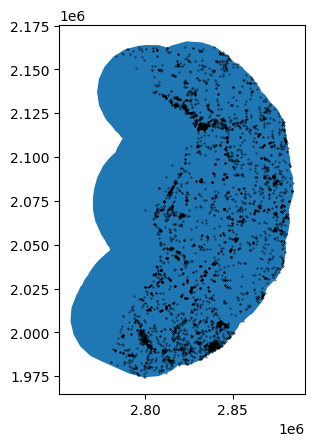

In [41]:
ax = studyAreaIN.plot()
ax = resdf[0].plot(ax=ax, c='k', markersize=0.1)

# Work here next!

# Interpolate thickness values in each layer

Loop through each layer and interpolate (use same parameters (?))

Ensure rasters align (are co-registered) with grid

Export to 

In [44]:
from scipy import interpolate

def layer_interp(points, grid, layers=None, method='nearest', lin_kind='cubic', export_dir=None, targetcol='TARG_THICK_PER', lyrcol='LAYER', xcol=None, ycol=None, xcoord='x', ycoord='y', **kwargs):
    """Function to interpolate wells to model grid

    Parameters
    ----------
    points : _type_
        _description_
    grid : _type_
        _description_
    kind : _type_
        _description_
    layers : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """
    nnList = ['nearest', 'nearest neighbor', 'nearestneighbor','neighbor',  'nn','n']
    splineList = ['interp2d', 'interp', 'spline', 'spl', 'sp', 's']
    linList = ['linear', 'lin', 'l']
    linKindList = ['linear', 'cubic', 'quintic']
    ctList = ['clough tocher', 'clough', 'cloughtocher', 'ct', 'c']
    rbfList = ['rbf', 'radial basis', 'radial basis function', 'r', 'radial']
    #k-nearest neighbors from scikit-learn?
    #kriging? (from pykrige or maybe also from scikit-learn)
    
        
    X = np.round(grid[xcoord].values, 2).astype(np.half) #Extract xcoords from grid
    Y = np.round(grid[ycoord].values, 2).astype(np.half) #Extract ycoords from grid
    
    if layers is None and (type(points) is list or type(points) is dict):
        layers = len(points)

    if len(points) != layers:
        print('You have specified a different number of layers than what is iterable in the points argument. This may not work properly.')

    daDict = {}
    for lyr in range(1, layers+1):
        if type(points) is list or type(points) is dict:
            pts = points[lyr-1]
            dataX = pts
        else:
            pts = points

        if xcol is None:
            dataX = pts['geometry'].x
        else:
            dataX = pts[xcol]
        
        if ycol is None:
            dataY = pts['geometry'].y
        else:
            dataY = pts[ycol]

        #layer = pts[lyrcol]        
        interpVal = pts[targetcol]
        pdinterp = pd.DataFrame(interpVal)
        if method.lower() in nnList:
            X, Y = np.meshgrid(X, Y, sparse=True) #2D Grid for interpolation
            X = X.astype(np.half)
            Y = Y.astype(np.half)
            dataPoints = np.array(list(zip(dataX, dataY)))
            interp = interpolate.NearestNDInterpolator(dataPoints, interpVal, **kwargs)
            Z = interp(X, Y).astype(np.half)
        elif method.lower() in linList:
            X, Y = np.meshgrid(X, Y, sparse=True) #2D Grid for interpolation
            X = X.astype(np.half)
            Y = Y.astype(np.half)
            interp = interpolate.LinearNDInterpolator(list(zip(dataX, dataY)), interpVal, **kwargs)
            Z = interp(X, Y).astype(np.half)
        elif method.lower() in ctList:
            X, Y = np.meshgrid(X, Y, sparse=True) #2D Grid for interpolation
            X = X.astype(np.half)
            Y = Y.astype(np.half)
            interp = interpolate.CloughTocher2DInterpolator(list(zip(dataX, dataY)), interpVal, **kwargs)
            Z = interp(X, Y).astype(np.half) 
        elif method.lower() in rbfList:
            dataXY=  np.column_stack((dataX, dataY)).astype(np.half)
            interp = interpolate.RBFInterpolator(dataXY, interpVal, **kwargs)
            print("Radial Basis Function does not work well with many well-based datasets. Consider instead specifying 'nearest', 'linear', 'spline', or 'clough tocher' for interpolation method.")
            Z = interp(np.column_stack((X.ravel(), Y.ravel()))).reshape(X.shape).astype(np.half)
        elif method.lower() in splineList:
            if lin_kind.lower() in linKindList:
                interp = interpolate.interp2d(dataX, dataY, interpVal, kind=lin_kind, **kwargs)
                Z = interp(X, Y).astype(np.half)
            elif lin_kind.lower() == 'bisplrep':
                Z = interpolate.bisplrep(dataX, dataY, interpVal, **kwargs).astype(np.half)
            else:
                X, Y = np.meshgrid(X, Y, sparse=True) #2D Grid for interpolation
                X = X.astype(np.half)
                Y = Y.astype(np.half)
                print("Specified kind of interpolation (lin_kind={}) not recognized, using 'cubic'.".format(lin_kind))
                interp = interpolate.interp2d(list(zip(dataX, dataY)), interpVal, kwargs, kind='cubic', **kwargs)
                Z = interp(X, Y).astype(np.half)
        else:
            print('Specified interpolation method not recognized, using nearest neighbor.')
            X, Y = np.meshgrid(X, Y, sparse=True) #2D Grid for interpolation
            interp = interpolate.NearestNDInterpolator(list(zip(dataX, dataY)), interpVal, **kwargs)
            Z = interp(X, Y).astype(np.half)

        #global ZTest
        #ZTest = Z

        interp_grid = xr.DataArray( #Create new datarray with new data values, but everything else the same
                    data=Z,
                    dims=grid.dims,
                    coords=grid.coords)

        del Z
        del dataX
        del dataY
        del interpVal
        del interp

        #interp_grid=interp_grid.interpolate_na(dim=x)
        zFillDigs = len(str(layers))
        daDict['Layer'+str(lyr).zfill(zFillDigs)] = interp_grid
        del interp_grid

        print('Completed interpolation for Layer '+str(lyr).zfill(zFillDigs))
    interp_dataset = xr.Dataset(daDict)

    print('Done with interpolation, getting global attrs')
    common_attrs = {}
    for i, (var_name, data_array) in enumerate(interp_dataset.data_vars.items()):
        if i == 0:
            common_attrs = data_array.attrs
        else:
            common_attrs = {k: v for k, v in common_attrs.items() if k in data_array.attrs and data_array.attrs[k] == v}
    interp_dataset.attrs.update(common_attrs)

    return interp_dataset

layers_dataset = layer_interp(points=resdf, layers=9, grid=modelGrid, method='lin')
layers_dataset

C:\Users\riley\AppData\Local\Temp\ipykernel_14888\3553469390.py:32: RuntimeWarning: overflow encountered in cast
  X = np.round(grid[xcoord].values, 2).astype(np.half) #Extract xcoords from grid
C:\Users\riley\AppData\Local\Temp\ipykernel_14888\3553469390.py:33: RuntimeWarning: overflow encountered in cast
  Y = np.round(grid[ycoord].values, 2).astype(np.half) #Extract ycoords from grid


Completed interpolation for Layer 1
Completed interpolation for Layer 2
Completed interpolation for Layer 3
Completed interpolation for Layer 4
Completed interpolation for Layer 5
Completed interpolation for Layer 6
Completed interpolation for Layer 7
Completed interpolation for Layer 8
Completed interpolation for Layer 9
Done with interpolation, getting global attrs


<xarray.Dataset>
Dimensions:      (x: 204, y: 307)
Coordinates:
    band         int32 1
  * x            (x) float64 2.757e+06 2.758e+06 ... 2.884e+06 2.884e+06
  * y            (y) float64 2.166e+06 2.165e+06 ... 1.975e+06 1.974e+06
    spatial_ref  int32 0
Data variables:
    Layer1       (y, x) float16 nan nan nan nan nan nan ... nan nan nan nan nan
    Layer2       (y, x) float16 nan nan nan nan nan nan ... nan nan nan nan nan
    Layer3       (y, x) float16 nan nan nan nan nan nan ... nan nan nan nan nan
    Layer4       (y, x) float16 nan nan nan nan nan nan ... nan nan nan nan nan
    Layer5       (y, x) float16 nan nan nan nan nan nan ... nan nan nan nan nan
    Layer6       (y, x) float16 nan nan nan nan nan nan ... nan nan nan nan nan
    Layer7       (y, x) float16 nan nan nan nan nan nan ... nan nan nan nan nan
    Layer8       (y, x) float16 nan nan nan nan nan nan ... nan nan nan nan nan
    Layer9       (y, x) float16 nan nan nan nan nan nan ... nan nan nan nan nan

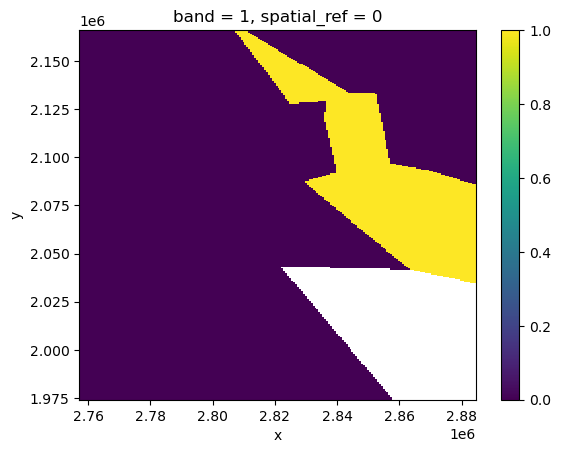

In [42]:
layers_dataset.plot()

In [43]:
points = resdf[0]

dataX = points['geometry'].x
dataY = points['geometry'].y
interpVal = points['TARG_THICK_PER']

X = modelGrid.coords['x'].values
Y = modelGrid.coords['y'].values

threshold=5
result = []
for i, x in enumerate(dataX):
    y = dataY[i]
    # Check if the current item is too close to any item in the result
    if not any(abs(np.sqrt((x-r[0])**2 + (y-r[1])**2)) < threshold for r in result):
        result.append([x, y, i])

data_X = []
data_Y = []
interp_V = []
for i in result:
    data_X.append(dataX[i[2]])
    data_Y.append(dataY[i[2]])
    interp_V.append(interpVal[i[2]])

X, Y = np.meshgrid(X, Y)

dataXY = np.column_stack((data_X, data_Y))


In [44]:
interp = interpolate.RBFInterpolator(dataXY, interp_V, neighbors=10)
Z = interp(np.column_stack((X.ravel(), Y.ravel()))).reshape(X.shape)

interp_grid = xr.DataArray( #Create new datarray with new data values, but everything else the same
            data=Z,
            dims=modelGrid.dims,
            coords=modelGrid.coords,
            attrs=modelGrid.attrs)

In [45]:
print(obs)

NameError: name 'obs' is not defined

In [ ]:
print(xobs.shape)
print(yobs.shape)
print(xflat.shape)
print(yflat.shape)

(100, 2)
(100,)
(2500, 2)
(2500,)


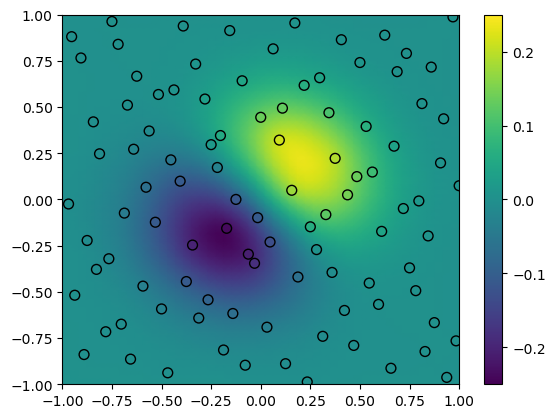

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RBFInterpolator
from scipy.stats.qmc import Halton
rng = np.random.default_rng()
xobs = 2*Halton(2, seed=rng).random(100) - 1
yobs = np.sum(xobs, axis=1)*np.exp(-6*np.sum(xobs**2, axis=1))
xgrid = np.mgrid[-1:1:50j, -1:1:50j]
xflat = xgrid.reshape(2, -1).T
yflat = RBFInterpolator(xobs, yobs)(xflat)
ygrid = yflat.reshape(50, 50)
fig, ax = plt.subplots()
ax.pcolormesh(*xgrid, ygrid, vmin=-0.25, vmax=0.25, shading='gouraud')
p = ax.scatter(*xobs.T, c=yobs, s=50, ec='k', vmin=-0.25, vmax=0.25)
fig.colorbar(p)
plt.show()

# Export

In [ ]:
#Export data 
downhole_bedrockDepth_XYZ.to_csv('\\\\isgs-sinkhole\\geophysics\\Balikian\\BedrockWellData\\Wells\\ProcessedWellData\\Downhole_BedrockPicks.csv',index_label="ID")
wPermits_XYZ.to_csv('\\\\isgs-sinkhole\\geophysics\\Balikian\\BedrockWellData\\Wells\\ProcessedWellData\\wPermits_BedrockPicks.csv',index_label="ID")